In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.cluster import KMeans, DBSCAN

### 1. App 可视化

In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
def get_node2id(file=None):
    if not file:
        file = '../resources/node2id.pkl'
    node2id = pickle.load(open(file, 'rb'))
    print('load node2id from %s, it has %s nodes' % (file, len(node2id)))
    return node2id

In [4]:
node2id = get_node2id()
id2node = {}
for node, val in node2id.items():
    if 25467 > val[0] >= 25413:
        id2node[val[0] - 25413] = node
del node2id
node2id = {}
for id,node in id2node.items():
    node2id[node] = id

load node2id from ../resources/node2id.pkl, it has 25486 nodes


In [5]:
ids = list(id2node.keys())
applist = list(id2node.values())

In [6]:
def get_embeddings(file_name, node2id):  # 每个节点的embedding向量，给dnn的lookup用
    """
    embeddings的节点有的存成id, 有的是名称需要node2id
    :param file_name: embeddings file
    :param node2id: node:[id, type, count]
    :return:
    """
    embeddings_file = os.path.join("../network_embedding/embeddings_output/", file_name)
    with open(embeddings_file, 'r') as f:
        shape = tuple(map(int, f.readline().split()))
        print('node: %s, embedding_size: %s' % shape)
        embeddings = np.zeros((54, 128))
        for line in f:
            splits = line.split()
            if line.startswith('金山'):
                embeddings[node2id['金山WPS OFFICE手机版']] = list(map(float, splits[2:]))
            elif splits[0] in node2id:
                embeddings[node2id[splits[0]]] = list(map(float, splits[1:]))
            elif splits[0].isdigit() and int(splits[0])-25413 in ids:
                embeddings[int(splits[0]) - 25413] = list(map(float, splits[1:]))
    return embeddings

In [14]:
deepwalk_embeddings = get_embeddings('deepwalk.embeddings', node2id)
hin2vec_embeddings = get_embeddings('node_vectors.txt', node2id)

node: 25486, embedding_size: 128
node: 25486, embedding_size: 128


### app_cat

In [76]:
app_cat = pd.read_csv('../resources/app_cat的副本.csv', sep='\t', encoding='gbk')
app_cat.to_csv('../resources/app_cat.csv', index=False, encoding='gbk')
app2cat = dict(zip(list(app_cat['app']), list(app_cat['app_cat'])))
app_cat

,app,app_cat
0,金山WPS OFFICE手机版,办公管理
1,百度云,办公管理
2,钉钉,办公管理
3,百度地图,便捷生活
4,高德地图,便捷生活
5,墨迹天气,便捷生活
6,58同城,便捷生活
7,京东商城,电子商务
8,苏宁,电子商务
9,蘑菇街,电子商务


In [240]:
colors=['#FFFAFA','#F8F8FF','#F5F5F5','#DCDCDC','#FFFAF0','#FDF5E6','#FAF0E6','#FAEBD7','#FFEFD5','#FFEBCD','#FFE4C4','#FFDAB9','#FFDEAD','#FFE4B5','#FFF8DC','#FFFFF0','#FFFACD','#FFF5EE','#F0FFF0','#F5FFFA','#F0FFFF','#F0F8FF','#E6E6FA','#FFF0F5','#FFE4E1','#FFFFFF','#000000','#2F4F4F','#696969','#708090','#778899','#BEBEBE','#D3D3D3','#191970','#000080','#6495ED','#483D8B','#6A5ACD','#7B68EE','#8470FF','#0000CD','#4169E1','#0000FF','#1E90FF','#00BFFF','#87CEEB','#87CEFA','#4682B4','#B0C4DE','#ADD8E6','#B0E0E6','#AFEEEE','#00CED1','#48D1CC','#40E0D0','#00FFFF','#E0FFFF','#5F9EA0','#66CDAA','#7FFFD4','#006400','#556B2F','#8FBC8F','#2E8B57','#3CB371','#20B2AA','#98FB98','#00FF7F','#7CFC00','#00FF00','#7FFF00','#00FA9A','#ADFF2F','#32CD32','#9ACD32','#228B22','#6B8E23','#BDB76B','#EEE8AA','#FAFAD2','#FFFFE0','#FFFF00','#FFD700','#EEDD82','#DAA520','#B8860B','#BC8F8F','#CD5C5C','#8B4513','#A0522D','#CD853F','#DEB887','#F5F5DC','#F5DEB3','#F4A460','#D2B48C','#D2691E','#B22222','#A52A2A','#E9967A','#FA8072','#FFA07A','#FFA500','#FF8C00','#FF7F50','#F08080','#FF6347','#FF4500','#FF0000','#FF69B4','#FF1493','#FFC0CB','#FFB6C1','#DB7093','#B03060','#C71585','#D02090','#FF00FF','#EE82EE','#DDA0DD','#DA70D6','#BA55D3','#9932CC','#9400D3','#8A2BE2','#A020F0','#9370DB','#D8BFD8','#FFFAFA','#EEE9E9','#CDC9C9','#8B8989','#FFF5EE','#EEE5DE','#CDC5BF','#8B8682','#FFEFDB','#EEDFCC','#CDC0B0','#8B8378','#FFE4C4','#EED5B7','#CDB79E','#8B7D6B','#FFDAB9','#EECBAD','#CDAF95','#8B7765','#FFDEAD','#EECFA1','#CDB38B','#8B795E','#FFFACD','#EEE9BF','#CDC9A5','#8B8970','#FFF8DC','#EEE8CD','#CDC8B1','#8B8878','#FFFFF0','#EEEEE0','#CDCDC1','#8B8B83','#F0FFF0','#E0EEE0','#C1CDC1','#838B83','#FFF0F5','#EEE0E5','#CDC1C5','#8B8386','#FFE4E1','#EED5D2','#CDB7B5','#8B7D7B','#F0FFFF','#E0EEEE','#C1CDCD','#838B8B','#836FFF','#7A67EE','#6959CD','#473C8B','#4876FF','#436EEE','#3A5FCD','#27408B','#0000FF','#0000EE','#0000CD','#00008B','#1E90FF','#1C86EE','#1874CD','#104E8B','#63B8FF','#5CACEE','#4F94CD','#36648B','#00BFFF','#00B2EE','#009ACD','#00688B','#87CEFF','#7EC0EE','#6CA6CD','#4A708B','#B0E2FF','#A4D3EE','#8DB6CD','#607B8B','#C6E2FF','#B9D3EE','#9FB6CD','#6C7B8B','#CAE1FF','#BCD2EE','#A2B5CD','#6E7B8B','#BFEFFF','#B2DFEE','#9AC0CD','#68838B','#E0FFFF','#D1EEEE','#B4CDCD','#7A8B8B','#BBFFFF','#AEEEEE','#96CDCD','#668B8B','#98F5FF','#8EE5EE','#7AC5CD','#53868B','#00F5FF','#00E5EE','#00C5CD','#00868B','#00FFFF','#00EEEE','#00CDCD','#008B8B','#97FFFF','#8DEEEE','#79CDCD','#528B8B','#7FFFD4','#76EEC6','#66CDAA','#458B74','#C1FFC1','#B4EEB4','#9BCD9B','#698B69','#54FF9F','#4EEE94','#43CD80','#2E8B57','#9AFF9A','#90EE90','#7CCD7C','#548B54','#00FF7F','#00EE76','#00CD66','#008B45','#00FF00','#00EE00','#00CD00','#008B00','#7FFF00','#76EE00','#66CD00','#458B00','#C0FF3E','#B3EE3A','#9ACD32','#698B22','#CAFF70','#BCEE68','#A2CD5A','#6E8B3D','#FFF68F','#EEE685','#CDC673','#8B864E','#FFEC8B','#EEDC82','#CDBE70','#8B814C','#FFFFE0','#EEEED1','#CDCDB4','#8B8B7A','#FFFF00','#EEEE00','#CDCD00','#8B8B00','#FFD700','#EEC900','#CDAD00','#8B7500','#FFC125','#EEB422','#CD9B1D','#8B6914','#FFB90F','#EEAD0E','#CD950C','#8B658B','#FFC1C1','#EEB4B4','#CD9B9B','#8B6969','#FF6A6A','#EE6363','#CD5555','#8B3A3A','#FF8247','#EE7942','#CD6839','#8B4726','#FFD39B','#EEC591','#CDAA7D','#8B7355','#FFE7BA','#EED8AE','#CDBA96','#8B7E66','#FFA54F','#EE9A49','#CD853F','#8B5A2B','#FF7F24','#EE7621','#CD661D','#8B4513','#FF3030','#EE2C2C','#CD2626','#8B1A1A','#FF4040','#EE3B3B','#CD3333','#8B2323','#FF8C69','#EE8262','#CD7054','#8B4C39','#FFA07A','#EE9572','#CD8162','#8B5742','#FFA500','#EE9A00','#CD8500','#8B5A00','#FF7F00','#EE7600','#CD6600','#8B4500','#FF7256','#EE6A50','#CD5B45','#8B3E2F','#FF6347','#EE5C42','#CD4F39','#8B3626','#FF4500','#EE4000','#CD3700','#8B2500','#FF0000','#EE0000','#CD0000','#8B0000','#FF1493','#EE1289','#CD1076','#8B0A50','#FF6EB4','#EE6AA7','#CD6090','#8B3A62','#FFB5C5','#EEA9B8','#CD919E','#8B636C','#FFAEB9','#EEA2AD','#CD8C95','#8B5F65','#FF82AB','#EE799F','#CD6889','#8B475D','#FF34B3','#EE30A7','#CD2990','#8B1C62','#FF3E96','#EE3A8C','#CD3278','#8B2252','#FF00FF','#EE00EE','#CD00CD','#8B008B','#FF83FA','#EE7AE9','#CD69C9','#8B4789','#FFBBFF','#EEAEEE','#CD96CD','#8B668B','#E066FF','#D15FEE','#B452CD','#7A378B','#BF3EFF','#B23AEE','#9A32CD','#68228B','#9B30FF','#912CEE','#7D26CD','#551A8B','#AB82FF','#9F79EE','#8968CD','#5D478B','#FFE1FF','#EED2EE','#CDB5CD','#8B7B8B','#1C1C1C','#363636','#4F4F4F','#696969','#828282','#9C9C9C','#B5B5B5','#CFCFCF','#E8E8E8','#A9A9A9','#00008B','#008B8B','#8B008B','#8B0000','#90EE90']
len(colors)
colors = np.random.choice(colors, 19)

In [256]:
# colorMap = {
# #     '电子商务': '#FF0033',  #红色
# #     '健康医疗': '#33CC33',  #绿色
#     '旅行预订': '#66CCFF',  #浅蓝
#     '汽车服务': '#333399',  #蓝紫
#     '通讯聊天': '#9933CC',  #紫色
#     '社交网络': '#FF6666',  #粉色
#     '音乐音频': '#FF9900',  #橙色
#     '便捷生活': '#33CC33',  #绿色
# }
colorMap = dict(zip(cat, colors))
colorMap['通讯聊天'] = '#9933CC'  #紫色
colorMap['社交网络'] = '#FF6666' #粉色
def get_color(app):
    cat = app2cat[app]
    if cat not in colorMap:
        return '#CCCCCC'
    return colorMap[cat]

In [335]:
from matplotlib.font_manager import FontProperties
font=FontProperties(fname='/Library/Fonts/Songti.ttc', size=6)

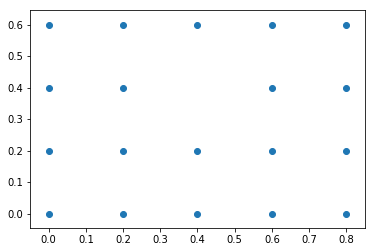

In [322]:
anchor = np.random.uniform(size=(19,2))
anchor = []
for i in np.arange(5):
    for j in np.arange(4):
        anchor.append([i, j])
anchor = np.array(anchor) * 0.2 
anchor = anchor[np.random.choice(20, 19, replace=False)]
fig = plt.figure()
plt.scatter(anchor[:,0], anchor[:, 1])
plt.show()

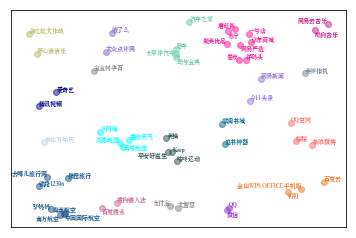

In [323]:
from adjustText import adjust_text
cat = sorted(set(app2cat.values()))
cat2id = dict(zip(cat, range(19)))
appid2catid = {}
for appid, app in id2node.items():
    appid2catid[appid] = cat2id[app2cat[app]]
fig = plt.figure()
data = PCA(n_components=3).fit_transform(hin2vec_embeddings)
xmin,xmax = data.min(),data.max()
data = (data-xmin)/(xmax-xmin)
texts = []
for i in range(data.shape[0]):
    color = get_color(id2node[i])
    if color:
        x = data[i, 2] + anchor[appid2catid[i], 0]
        y = data[i, 1] + anchor[appid2catid[i], 1]
        plt.scatter(x, y, alpha=0.5, color=color)
        texts.append(plt.text(x, y, str(id2node[i]), fontproperties=font, color=color))
adjust_text(texts, only_move={'points':'y', 'text':'y'}) 
plt.xticks([])
plt.yticks([])
plt.savefig('./output/hin2vec.jpg', dpi=400)
plt.show()
!open output/hin2vec.jpg

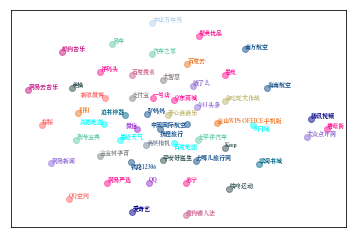

In [372]:
fig = plt.figure()
data = TSNE(n_components=2).fit_transform(deepwalk_embeddings)
xmin,xmax = data.min(),data.max()
data = (data-xmin)/(xmax-xmin)
texts = []
for i in range(data.shape[0]):
    color = get_color(id2node[i])
    if color:
        x = data[i, 0]
        y = data[i, 1]
        plt.scatter(x, y, alpha=0.5, color=color)
        texts.append(plt.text(x, y, str(id2node[i]), fontproperties=font, color=color))
adjust_text(texts, only_move={'points':'y', 'text':'y'}) 
plt.xticks([])
plt.yticks([])
plt.savefig('./output/deepwalk.jpg', dpi=400)
plt.show()
!open output/deepwalk.jpg

In [370]:
def reduction_and_plot(model, data, file):
#     xmin, xmax = np.min(data, axis=0, keepdims=True), np.max(data, axis=0, keepdims=True)
#     data = (data - xmin)/(xmax - xmin)
#     data = data/np.sqrt(np.sum(np.square(data), axis=1, keepdims=True))
    data = model(n_components=4).fit_transform(data)
    fig = plt.figure()
    for i in range(data.shape[0]):
        if id2node[i] in ['搜狗输入法', 'QQ空间', '网易云音乐']:
            continue
        color = get_color(id2node[i])
        if color:
            plt.scatter(data[i, 1], data[i, 2], alpha=0.5, color=color)
            plt.text(data[i, 1], data[i, 2], str(id2node[i]), fontproperties=font,
                     color=color)
#                      fontdict={'weight': 'bold', 'size': 10})
    plt.xticks([])
    plt.yticks([])
    plt.savefig(file, dpi=400)
    plt.show()

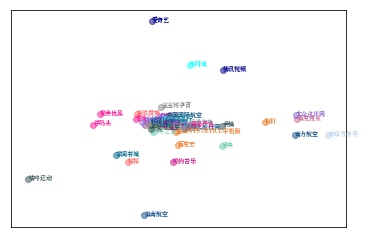

In [371]:
reduction_and_plot(PCA, deepwalk_embeddings, './output/deepwalk.jpg')
!open output/deepwalk.jpg

### 2. 余弦距离

In [151]:
def cosine(x,y):
    return np.sum(x*y)/(np.linalg.norm(x) * np.linalg.norm(y))

In [152]:
x = np.array([1,2])
y = np.array([1,2])
np.linalg.norm(x)

2.2360679774997898

In [154]:
x = np.array([1,0])
y = np.array([0,2])
cosine(x,y)

0.0

In [175]:
node2id

{'58同城': 38,
 'Keep': 11,
 'QQ': 0,
 'QQ空间': 29,
 '一号店': 25,
 '中华万年历': 35,
 '中国国际航空': 53,
 '京东商城': 19,
 '今日头条': 8,
 '南方航空': 40,
 '卷皮': 48,
 '去哪儿旅行网': 32,
 '咕咚运动': 51,
 '墨迹天气': 23,
 '大众点评网': 9,
 '大智慧': 37,
 '太平洋汽车': 33,
 '宝宝树孕育': 28,
 '平安好医生': 31,
 '开心消消乐': 2,
 '微信': 1,
 '掌阅书城': 27,
 '探探': 47,
 '搜狗输入法': 12,
 '携程旅行': 20,
 '支付宝': 14,
 '新浪微博': 3,
 '易车': 45,
 '汽车之家': 5,
 '洋码头': 49,
 '海南航空': 52,
 '爱奇艺': 18,
 '百度云': 21,
 '百度地图': 7,
 '百度搜索': 4,
 '网易严选': 44,
 '网易云音乐': 10,
 '网易新闻': 15,
 '美柚': 43,
 '美颜相机': 26,
 '聚美优品': 22,
 '腾讯视频': 6,
 '苏宁': 17,
 '蘑菇街': 30,
 '贪吃蛇大作战': 24,
 '追书神器': 34,
 '酷狗音乐': 16,
 '金山WPS OFFICE手机版': 46,
 '钉钉': 42,
 '铁路12306': 39,
 '饿了么': 36,
 '驴妈妈': 41,
 '驾考宝典': 50,
 '高德地图': 13}

In [155]:
node2id['中国国际航空'],node2id['海南航空'],node2id['南方航空'],node2id['微信'],node2id['QQ']

(53, 52, 40, 1, 0)

In [159]:
# 中国国际航空， 海南航空
cosine(deepwalk_embeddings[53], deepwalk_embeddings[52]), cosine(hin2vec_embeddings[53], hin2vec_embeddings[52])

(0.065774633981105057, 0.95788760904166659)

In [161]:
# 中国国际航空，南方航空
cosine(deepwalk_embeddings[53], deepwalk_embeddings[40]), cosine(hin2vec_embeddings[53], hin2vec_embeddings[40])

(0.062914119908291585, 0.88248756059140288)

In [163]:
# 海南航空，南方航空
cosine(deepwalk_embeddings[52], deepwalk_embeddings[40]), cosine(hin2vec_embeddings[52], hin2vec_embeddings[40])

(0.04357321442138995, 0.84857839452407913)

In [160]:
# 中国国际航空，微信
cosine(deepwalk_embeddings[53], deepwalk_embeddings[0]), cosine(hin2vec_embeddings[0], hin2vec_embeddings[53])

(0.10410818652120829, -0.68654274621316314)

In [162]:
# 微信，QQ
cosine(deepwalk_embeddings[1], deepwalk_embeddings[0]), cosine(hin2vec_embeddings[1], hin2vec_embeddings[0])

(0.16023188307399253, 0.99291841346586596)

In [164]:
node2id['支付宝'], node2id['百度搜索'], node2id['腾讯视频'], node2id['开心消消乐']

(14, 4, 6, 2)

In [165]:
#微信，支付宝
cosine(deepwalk_embeddings[1], deepwalk_embeddings[14]), cosine(hin2vec_embeddings[1], hin2vec_embeddings[14])

(0.5175179128171431, 0.98990812827053531)

In [166]:
#微信，腾讯视频
cosine(deepwalk_embeddings[1], deepwalk_embeddings[6]), cosine(hin2vec_embeddings[1], hin2vec_embeddings[6])

(0.034727533349282691, 0.99161182532403092)

In [168]:
#微信，开心消消乐
cosine(deepwalk_embeddings[1], deepwalk_embeddings[2]), cosine(hin2vec_embeddings[1], hin2vec_embeddings[2])

(0.45601947974050644, 0.99236060401722781)

In [169]:
node2id['易车'],node2id['汽车之家'],node2id['太平洋汽车'], node2id['驾考宝典']

(45, 5, 33, 50)

In [170]:
# 易车，太平洋汽车
cosine(deepwalk_embeddings[45], deepwalk_embeddings[33]), cosine(hin2vec_embeddings[45], hin2vec_embeddings[33])

(0.10166851989514235, 0.74390786757885119)

In [172]:
# 易车，驾考宝典
cosine(deepwalk_embeddings[45], deepwalk_embeddings[50]), cosine(hin2vec_embeddings[45], hin2vec_embeddings[50])

(0.078137730836834826, 0.72653801142592978)

In [171]:
# 易车，汽车之家
cosine(deepwalk_embeddings[45], deepwalk_embeddings[5]), cosine(hin2vec_embeddings[45], hin2vec_embeddings[5])

(0.08026763173938653, 0.31687233497754891)

In [173]:
node2id['网易云音乐'],node2id['酷狗音乐'],node2id[]

(10, 16)

In [174]:
# 网易云音乐，酷狗音乐
cosine(deepwalk_embeddings[10], deepwalk_embeddings[16]), cosine(hin2vec_embeddings[10], hin2vec_embeddings[16])

(0.022547125157545658, 0.86211322150475067)

In [176]:
# 网易云音乐，网易新闻
cosine(deepwalk_embeddings[10], deepwalk_embeddings[15]), cosine(hin2vec_embeddings[10], hin2vec_embeddings[15])

(0.094198421028412319, 0.92066382632023103)

In [177]:
# 网易云音乐，网易严选
cosine(deepwalk_embeddings[10], deepwalk_embeddings[44]), cosine(hin2vec_embeddings[10], hin2vec_embeddings[44])

(0.039416622813176865, 0.53844973372429716)

In [178]:
# 一号店，聚美优品
cosine(deepwalk_embeddings[25], deepwalk_embeddings[22]), cosine(hin2vec_embeddings[25], hin2vec_embeddings[22])

(0.11834424425919902, 0.66653575559399891)

In [179]:
# 一号店，蘑菇街
cosine(deepwalk_embeddings[25], deepwalk_embeddings[30]), cosine(hin2vec_embeddings[25], hin2vec_embeddings[30])

(0.05946539930229601, 0.7534784512416437)

In [182]:
# 一号店，网易严选
cosine(deepwalk_embeddings[25], deepwalk_embeddings[44]), cosine(hin2vec_embeddings[25], hin2vec_embeddings[44])

(0.14491501917734234, 0.64158260392679844)

In [184]:
# 一号店，京东商城
cosine(deepwalk_embeddings[25], deepwalk_embeddings[19]), cosine(hin2vec_embeddings[25], hin2vec_embeddings[19])

(0.57960179785798016, 0.74807762528729405)

In [186]:
cosine(deepwalk_embeddings[25], deepwalk_embeddings[49]), cosine(hin2vec_embeddings[25], hin2vec_embeddings[49])

(0.11897880509257702, -0.01400188511653325)

In [187]:
# 苏宁，京东
cosine(deepwalk_embeddings[17], deepwalk_embeddings[19]), cosine(hin2vec_embeddings[17], hin2vec_embeddings[19])

(0.15789951915141645, 0.79628270357019493)

In [189]:
# 一号店，苏宁
cosine(deepwalk_embeddings[25], deepwalk_embeddings[17]), cosine(hin2vec_embeddings[25], hin2vec_embeddings[17])

(0.19354540180579299, 0.79523522975130789)

In [190]:
# 易车，网易云音乐
cosine(deepwalk_embeddings[45], deepwalk_embeddings[10]), cosine(hin2vec_embeddings[45], hin2vec_embeddings[10])

(0.047470726457337763, 0.2798278497190817)

In [193]:
# 一号店，易车
cosine(deepwalk_embeddings[25], deepwalk_embeddings[45]), cosine(hin2vec_embeddings[25], hin2vec_embeddings[45])

(0.18679328734709597, 0.47588563776777298)

In [194]:
# 一号店，微信
cosine(deepwalk_embeddings[25], deepwalk_embeddings[1]), cosine(hin2vec_embeddings[25], hin2vec_embeddings[1])

(0.57727964695915956, 0.71345517244481238)

In [196]:
# 一号店，网易云音乐
cosine(deepwalk_embeddings[25], deepwalk_embeddings[10]), cosine(hin2vec_embeddings[25], hin2vec_embeddings[10])

(0.097070330773367658, 0.76386364275097773)